# Part 1

In [751]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math as mt

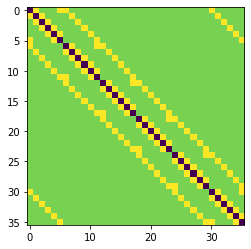

Число обусловленности 2.148829671478769e+16


In [807]:
def matrix_A(N):
    A = np.zeros( (2*N,)*4 ) # Матрица разрежена, значит начинаем с нулевой матрицы.
    k = np.arange(2*N)[:,None] # Все возможные значения индекса для x координаты.
    kplus = ((k+1)%(2*N)) # Ячейка правее, чем указанная в массиве k.
    n = np.arange(2*N)[None,:] # Все возможные значения индекса для y координаты.
    nplus = ((n+1)%(2*N)) # Ячейка выше, чем указанная в массиве n.
    A[k,n,k,n] = -4*N**2 # Устанавливаем все диагональные элементы.
    A[k,nplus,k,n] = N**2 # Устанавливаем значения для соседей по вертикали.
    A[k,n,k,nplus] = N**2 
    A[kplus,n,k,n] = N**2 # и по горизонтали.
    A[k,n,kplus,n] = N**2 
    return A

def flatten_matrix(A):
    """Преобразует матрицу со сложными индексами в обучную матрицу в числовыми индексами."""
    N, M, N1, M1 = A.shape
    return A.reshape((N*M, N1*M1))


n = 3

# Посмотрим на структуру матрицы.
A=matrix_A(n)
plt.imshow(flatten_matrix(A)) # Для отрисовки приведем ее к обычному виду - квадратному массиву.
plt.show()
# Матрица разреженная, причем ее можно представить трехдиагональном виде, однако на диагонали стоят блоки.

print("Число обусловленности", np.linalg.cond(flatten_matrix(A)))
# Число обусловленности получается около 6e16, а значит решение систем с такой матрицей не дает 
# ни одного верного знака в ответе.

Ошибка решения: 0.07276755461170926
Невязка на численном решении: 7.074811187622318e-15
Невязка на аналитическом решении: 1.7763568394002505e-15


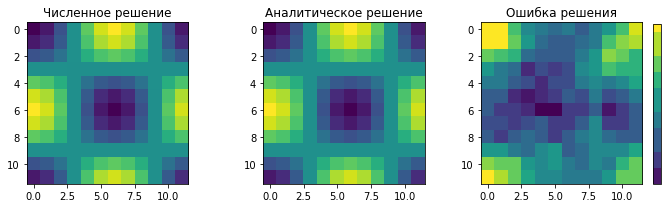

In [691]:

def grid_x(N): 
    """Считает сетку для координаты x."""
    return np.arange(2*N)/N-1

def grid_y(N): 
    """Считает сетку для координаты y."""
    return np.arange(2*N)/N-1
    
def problem_1(N):
    """
    Возвращает пару (f, u), где 
        `f` - правая часть уравнения Пуассона в узлах решетки,
        `u` - аналитическое решение ДИСКРЕТИЗОВАННОГО уравнения Пуассона с правой частью `f`.
    """
    x, y = grid_x(N)[:,None], grid_y(N)[None,:]
    f = np.cos(np.pi*x)*np.cos(np.pi*y)
    mu = 4*(np.cos(np.pi/N)-1)*N**2 # Собственное значение дискретизации оператора Лапласа отвечающее f.
    u = f/mu
    return f, u
    
def solve_poisson_using_np(f):
    """
    Решает уравнение Пуассона с заданной правой частью `f`.
    Возвращает решение `u` и невязку `r`.
    """
    N = f.shape[0]//2
    A = matrix_A(N)
    Af = flatten_matrix(A) # Превращаем мультииндекс в целое число.
    ff = f.flatten()
    u = np.linalg.solve( Af, ff )
    r = ff-Af@u
    return u.reshape(f.shape), r.reshape(f.shape)


N = 2*n
f, u0 = problem_1(N)
u, r = solve_poisson_using_np(f)
# print("Приближенное решение:", u[:5,:5] )
# print("Точное решение:", u0[:5,:5] )
# print("Ошибка:", u[:5,:5] - u0[:5,:5] )
print("Ошибка решения:", np.linalg.norm( (u-u0).flatten(), ord=np.inf ))
print("Невязка на численном решении:", np.linalg.norm( (r).flatten(), ord=np.inf ))

Af = flatten_matrix(matrix_A(N))
r0 = f.flatten()-Af@u0.flatten()
print("Невязка на аналитическом решении:", np.linalg.norm( (r0).flatten(), ord=np.inf ))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.imshow(u.T)
ax2.imshow(u0.T)
im=ax3.imshow((u-u0).T)
plt.colorbar(im, ax=ax3)
ax1.set_title("Численное решение")
ax2.set_title("Аналитическое решение")
ax3.set_title("Ошибка решения")
plt.tight_layout()
plt.show()

# Визуальное решение получилось очень похожим на верное, однако ошибка решения очень велика, хотя невязка мала.

In [692]:
# Можно заметить, что численное решение отличается на константу от аналитического.
print("Среднее значение численного решения:", np.mean(u))
print("Среднее значение аналитического решения", np.mean(u0))
# Так как решение уравнения Пуассона с периодическими граничными условиями определено не однозначно,
# и мы никак не ограничивали свободу решения, то не удивительно, что мы получили не ожидаемое решение.
# Попробуем вычесть среднее и снова посчитаем ошибку.
u_corrected = u-np.mean(u)
print("Ошибка решения с поправкой на константу:", np.linalg.norm( (u_corrected-u0).flatten(), ord=np.inf ))
# Ошибка стала меньше, но не исчезла совсем.

Среднее значение численного решения: -0.07276755461170915
Среднее значение аналитического решения 0.0
Ошибка решения с поправкой на константу: 1.3183898417423734e-16


In [693]:
def solve_poisson_fix1(f):
    """
    Решает уравнение Пуассона, делая поправку на постоянных функциях.
    """
    N = f.shape[0]//2
    A = matrix_A(N)
    # Превращаем мультииндекс в целое число.
    Af = flatten_matrix(A) 
    ff = f.flatten()
    # Исправляем поведение на постоянных функциях.
    Af -= 1/N
    ff -= np.mean(ff)
    # Матрица обусловлена теперь гораздо лучше.
#     print(f"Число обусловленности исправленной системы", np.linalg.cond(Af))
    # Решаем систему.
    u = np.linalg.solve( Af, ff )
    r = ff-Af@u
    return u.reshape(f.shape), r.reshape(f.shape)

f, u0 = problem_1(20)
u, r = solve_poisson_fix1(f)
print(f"Среднее значение численного решения:", np.mean(u))
print("Невязка:", np.linalg.norm( (r).flatten(), ord=np.inf ))
print("Ошибка решения:", np.linalg.norm( (u-u0).flatten(), ord=np.inf ))

Среднее значение численного решения: 4.6837533851373795e-18
Невязка: 5.5289106626332796e-14
Ошибка решения: 4.649058915617843e-16


# Part 2

In [7]:
%%html
<!-- Скобки вокруг матрицы согласно https://stackoverflow.com/questions/11561137/html-css-for-brackets-around-mathematical-matrix-prefer-lightweight/11561235 --> 
<style>
    .matrix { position: relative; left: 6px; } 
    .matrix:before, .matrix:after { content: ""; position: absolute; top: 0; border: 1px solid #000; width: 6px; height: 100%; } 
    .matrix:before { left: -6px; border-right: 0; } 
    .matrix:after { right: -6px; border-left: 0; }
</style>

In [8]:
# Для того, чтобы ваше решение затем можно было переиспользовать и далее расширять, будет предпочтительным
# реализовать классы для матриц специального вида, реализующих общий интерфейс, позволяющий решать системы
# с этими матрицами и производить другие необходимые операции наиболее эффективным для каждого типа матриц способом.

from IPython.display import HTML, display

# Определим базовых класс, который будет выполнять операции с матрицами,
# приводя их к заполеннными и обрабатывая их функциями из numpy.
class Matrix:
    @property
    def shape(self): # Должно возвращать размер матрицы, но в базовом классе размер не известен.
        raise NotImplementedError() 
    def __add__(self, other): # Операция сложения матриц
        if isinstance(other, Matrix): # Определим сложение матрицы с матрицей.
            # Корректность операции нужно проверять, но numpy это уже делает.
#             assert self.shape == other.shape, "Несовпадение размеров" 
            return DenseMatrix(self.to_dense()+other.to_dense())
        else: return NotImplemented
    # Аналогично можно определить вычитание __sub__, поэлементное умножение __mul__ и т.п.
    # См. полный список операторов https://docs.python.org/3/library/operator.html
    def __matmul__(self, other): # Матричное умножение self@other.
        return DenseMatrix(self.to_dense()@other.to_dense())
    def solve(self, b):
        """Решает систему self@u=b."""
        assert self.shape[0]==b.shape[0]
        return np.linalg.solve(self.to_dense(), b.to_dense())
    def _repr_html_(self): # Jupyter может выводить объекты в разных видах, например, выведем матрицу в виде таблицы.
        return f'<table class="matrix">'+"".join([ '<tr>'+"".join([f"<td>{c}</td>" for c in row])+'</tr>' for row in self.to_dense() ])+'</table>'

# Реализация матриц, хранящая заполненную матрицу.
class DenseMatrix(Matrix):
    def __init__(self, data):
        """Создает плотную матрицу с коэффициентами из массива `data`."""
        self._data = np.array(data) # Сохраняем коэффициенты в приватной переменной преобразую в numpy.ndarray.
        assert self._data.ndim==2 # Проверим корректность данных.
    def __getitem__(self, key): # Извлечение элемента матрицы (или подматрицы).
        return self._data[key]
    def to_dense(self): # Преобразует матрицу к плотной матрице в виде массива numpy.
        return self._data # Возращается НЕ копия, возвращаемый массив не должен изменяться.
    @property
    def shape(self): # Возвращает размер матрицы
        return self._data.shape

    
a = DenseMatrix([[1,0],[0,2]])
b = DenseMatrix([[1,1],[0,1]])
display(a)
display(b)
display(a+a@b)

1,0
0,2


1,1
0,1


2,1
0,4


In [9]:
# Ленточные матрицы (имеющие небольшое число ненулевых диагоналей) дают пример матриц,
# которые можно хранить значительно компактнее матриц общего назначения, 
# расчеты с ними быстрее, чем с заполненными матрицами.
class BandMatrix(Matrix):
    def __init__(self, diagonal, lower_diagonals=[], upper_diagonals=[]):
        """
        Создает ленточную матрицу.
        `diagonal` - список элементов главной диагонали,
        `lower_diagonals` - список диагоналей ниже главной, начиная с ближайшей к главной.
        `upper_diagonals` - список диагоналей выше главной, начиная с ближайшей к главной.
        """
        self._diagonal = diagonal
        self._lower_diagonals = lower_diagonals
        self._upper_diagonals = upper_diagonals
    @property
    def n(self): return len(self._diagonal) # Размер матрицы (матрица всегда квадратная).
    @property
    def p(self): return len(self._lower_diagonals) # Число диагоналей ниже главной.
    @property
    def q(self): return len(self._upper_diagonals) # Число диагоналей выше главной.
    @property
    def shape(self): # Переопределяем вычисление размера 
        return (self.n,)*2
    def __getitem__(self, key): # Извлечение элемента матрицы (или подматрицы).
        (i,j) = key # Распаковываем индексы матрицы.
        d = j-i # Номер диагонали, верхние с плюсом.
        if d>self.q or d<-self.p: return 0 # Элемент вне ленты.
        n = (j+i-abs(d))//2 # Номер элемента на диагонали (считая от верхнего/левого элемента).
        return (self._diagonal[n] if d==0 else 
                self._upper_diagonals[d-1][n] if d>0 else 
                self._lower_diagonals[-d-1][n])
    def to_dense(self): # Преобразует матрицу к плотной матрице в виде массива numpy.
        result = np.zeros(self.shape)
        for i in range(self.shape[0]):
            for j in range(self.shape[1]): # TODO Можно перебирать меньше элементов.
                result[i,j] = self[i,j]
        return result
    
    def to_band(self): # Преобразование NumPy массива к ленточному виду
        
        return 0
    def __add__(self, other): # Операция сложения матриц
        if isinstance(other, BandMatrix):
            # Корректность операции нужно проверять, но numpy это уже делает.
            assert self.shape == other.shape, "Несовпадение размеров"
            
            res = BandMatrix(diagonal=[], lower_diagonals=[], upper_diagonals=[])            
            up_min = min(self.q, other.q)
            down_min = min(self.p, other.p)
            
            for k in range(up_min):
                res._upper_diagonals += [(np.array(self._upper_diagonals[k]) + np.array(other._upper_diagonals[k])).flatten().tolist()]      
            for k in range(down_min):
                res._lower_diagonals += [(np.array(self._lower_diagonals[k]) + np.array(other._lower_diagonals[k])).flatten().tolist()]

            res._diagonal = (np.array(self._diagonal) + np.array(other._diagonal)).flatten().tolist()            

            if self.p < other.p:
                res._lower_diagonals += other._lower_diagonals[-(other.p - self.p):]
            if self.p > other.p:
                res._lower_diagonals += self._lower_diagonals[-(self.p - other.p):]
            if self.q < other.q:
                res._upper_diagonals += other._upper_diagonals[-(other.p - self.p):]
            if self.q > other.q:
                res._upper_diagonals += self._upper_diagonals[-(self.p - other.p):]       
                
            return DenseMatrix(res.to_dense())
        else: return NotImplemented


    def __neg__(self): # Возвращает противоположные значения элементов
        for i in range(len(self._lower_diagonals)):
            for j in range(len(self._lower_diagonals[i])):
                self._lower_diagonals[i][j] = -self._lower_diagonals[i][j]
                    
        for i in range(len(self._upper_diagonals)):
            for j in range(len(self._upper_diagonals[i])):
                self._upper_diagonals[i][j] = -self._upper_diagonals[i][j] 
                    
        for i in range(len(self._diagonal)):
            self._diagonal[i] = -self._diagonal[i]                    

        return self
        
    def __sub__(self, other): # Операция вычитания матриц
        if isinstance(other, BandMatrix): 
            # Корректность операции нужно проверять, но numpy это уже делает.
            assert self.shape == other.shape, "Несовпадение размеров"
            
            other = -other
            self = self + other

            return DenseMatrix(self.to_dense())
        else: return NotImplemented
    
    @property    
    def T(self): #Транспонирование матрицы            
        self._lower_diagonals, self._upper_diagonals = self._upper_diagonals, self._lower_diagonals
            
        return self
        
    def __matmul__(self, other): #дописать перевод обратно в ленточный вид для перемножения матриц
        vec = False
        if isinstance(other, BandMatrix):
            B = DenseMatrix(other.to_dense())
        elif (not(isinstance(other, BandMatrix))) and (len(other) == self.n):
            other = BandMatrix(diagonal = other)
            B = DenseMatrix(other.to_dense())
            vec = True
        else: return NotImplemented
            
        res = np.zeros((self.n,self.n))
        A = DenseMatrix(self.to_dense())
            
        for i in range(self.n):
            for j in range(self.n):
                up = min(min(self.n - 1, i + self.q), min(self.n - 1, j + other.p)) + 1
                down = max(max(0, j - other.q), max(0, i - self.p))
                buf = 0
                for k in range(down, up):
                    buf += A[i][k] * B[k][j]
                res[i][j] = buf
            
        if vec == True:
            res = np.sum(res, axis = 1)
            
        return res

    def solver(self, vector):
        if (self.p <= 1) and (self.q <= 1):
            alpha = np.zeros(self.n)
            beta = np.zeros(self.n)
                
            up_diag = self._upper_diagonals[0] + [0]
            low_diag = [0] + self._lower_diagonals[0]
            diag = self._diagonal
                
            alpha[1] = -up_diag[0]/diag[0]
            beta[1] = vector[0]/diag[0]

            for i in range(1,self.n-1):
                alpha[i+1] = -up_diag[i]/(low_diag[i] * alpha[i] + diag[i])
                beta[i+1] = (vector[i] - low_diag[i] * beta[i])/(low_diag[i] * alpha[i] + diag[i])
                
            sol = np.zeros(self.n)
            sol[-1] = (vector[-1] - low_diag[-1] * beta[-1])/(diag[-1] + alpha[-1] * low_diag[-1])
            for i in range(self.n-2,-1,-1):
                sol[i] = alpha[i+1] * sol[i+1] + beta[i+1]
                
            return(sol)
                
        else: return 'Not a tridiagonal matrix'
            
        
a = BandMatrix(diagonal=[1,2,3,4], lower_diagonals=[[5,6,7],[8,9]], upper_diagonals=[[10,11,12]])
b = BandMatrix(diagonal=[1,1,1,1], lower_diagonals=[[2,2,2]])
d = [1, 2, 3, 4]
display(a@b)
display(b@d)

array([[21., 10.,  0.,  0.],
       [ 9., 24., 11.,  0.],
       [20., 12., 27., 12.],
       [18., 23., 15.,  4.]])

array([ 1.,  4.,  7., 10.])

In [10]:
# Решение через NumPy
A = np.array([[1,2,0,0,0], [3,1,2,0,0], [0,3,1,2,0], [0,0,3,1,2], [0,0,0,3,1]])
b = [3, 4, 5, 6, 7]
x1 = np.linalg.solve(A,b)
print(x1)
print(A @ x1)

[ 1.28235294  0.85882353 -0.35294118  1.38823529  2.83529412]
[3. 4. 5. 6. 7.]


In [11]:
# Решение методом прогонки для ленточных (трехдиагональных) матриц
C = BandMatrix(diagonal=[1, 1, 1, 1 ,1], lower_diagonals=[[3, 3, 3, 3]], upper_diagonals=[[2, 2, 2, 2]])
x3 = C.solver(b)
print(x3)
print(C @ x3)

[ 1.28235294  0.85882353 -0.35294118  1.38823529  2.83529412]
[3. 4. 5. 6. 7.]


In [689]:
def LU_composition(A):
    lu = np.matrix(np.zeros([A.shape[0], A.shape[1]]))
    n = A.shape[0]
    for k in range(n):
        for j in range(k, n):
            lu[k, j] = A[k, j] - lu[k, :k] * lu[:k, j]
        for i in range(k + 1, n):
            lu[i, k] = (A[i, k] - lu[i, : k] * lu[: k, k]) / lu[k, k]
    L = lu.copy()
    for i in range(L.shape[0]):
        L[i, i] = 1
        L[i, i+1 :] = 0
    U = lu.copy()
    for i in range(1, U.shape[0]):
        U[i, :i] = 0
        
    return(L,U)

def LU_solver(A,b):
    def L_solver(L,b):
        x = np.zeros(b.shape[0])
        for j in range(b.shape[0]):
            x[j] = b[j]
            for i in range(j):
                x[j] = x[j] - (L[j,i])*x[i]
        return(x)
    
    def U_solver(U,b):
        x = np.zeros(b.shape[0])
        for j in range(b.shape[0]-1,-1,-1):
            x[j] = b[j]
            for i in range(b.shape[0]-1,j,-1):
                x[j] = x[j] - (U[j,i])*x[i]
            x[j] = x[j]/U[j,j]
        return(x)    
        
    L, U = LU_composition(A)
    y = L_solver(L,b)
    x = U_solver(U, y)
    return(x)

def LU_det(A):
    L, U = LU_composition(A)
    det = 1
    for i in range(U.shape[0]):
        det = det * U[i,i]
    return det

In [13]:
# Решение через LU-разложение методом прямой и обратной подстановки
A = np.array([[1,2,0,0,0], [3,1,2,0,0], [0,3,1,2,0], [0,0,3,1,2], [0,0,0,3,1]])
b = np.array([3, 4, 5, 6, 7])
x2 = LU_solver(A,b)
print(x2)
print(A @ x2)

[ 1.28235294  0.85882353 -0.35294118  1.38823529  2.83529412]
[3. 4. 5. 6. 7.]


In [676]:
# Блочные матрицы
class BlockMatrix(Matrix):
    def __init__(self, blocks=[]):
        """
        Создает блочную матрицу.
        `blocks` - матрица блоков
        """
        self._blocks = blocks       

    @property
    def shape(self): # Вычисление размера
        return self.block.shape
    
    @property
    def block(self):
        return np.block(self._blocks)
    
    def __getitem__(self, key): # Извлечение элемента матрицы (или подматрицы).
        (i,j) = key # Распаковываем индексы матрицы.
        return self.block[i][j]
    
#     def __setitem__(self, key, value):
#         (i,j) = key
#         self.block[i][j] = value

    def __add__(self, other):
        if isinstance(other, BlockMatrix):
            assert self.shape == other.shape, "Несовпадение размеров"
            buf = copy.deepcopy(self._blocks)
            res = BlockMatrix(buf)
            for i in range(len(self._blocks)):
                for j in range(len(self._blocks[i])):
                    if len(self._blocks) == len(other._blocks):
                        res._blocks[i][j] = self._blocks[i][j] + other._blocks[i][j]
                    else:
                        print('Different block sizes')
                        pass
                    
            return res         
        else: return NotImplemented

    def __neg__(self):
        buf = copy.deepcopy(self._blocks)
        res = BlockMatrix(buf)
        for i in range(len(self._blocks)):
            for j in range(len(self._blocks[i])):
                res._blocks[i][j] = -self._blocks[i][j]
            
        return res

    def __sub__(self, other): # Операция вычитания матриц
        if isinstance(other, BlockMatrix): 
            assert self.shape == other.shape, "Несовпадение размеров"
            
            buf = copy.deepcopy(self._blocks)
            res = BlockMatrix(buf)       
            other = -other
            res = self + other
            return res
        else: return NotImplemented
 
    def __matmul__(self, other):
        if not isinstance(other, BlockMatrix):
            return NotImplemented
        assert self.shape[1] == other.shape[0]
        
        buf = copy.deepcopy(self._blocks)
        res = BlockMatrix(buf)
        
        for i in range(len(res._blocks)):
            for j in range(len(res._blocks[i])):
                buf = np.zeros(res._blocks[i][j].shape, dtype = float )
                for k in range(len(res._blocks)):
                    buf += (np.array(self._blocks[i][k]) @ np.array(other._blocks[k][j]))
                res._blocks[i][j] = buf
                
        return res
  
    def to_dense(self): # Преобразует матрицу к плотной матрице в виде массива numpy.
        return self.block


In [681]:
a = np.array([[1,1],[1,1]])
b = np.array([[2,2],[2,2]])
c = np.array([[3,3],[3,3]])
d = np.array([[4,4],[4,4]])

In [682]:
blocks = [[a,b],[c,d]]

In [683]:
blocks1 = [[np.array([[1,0],[0,1]]),np.array([[0,0],[0,0]])],[np.array([[0,0],[0,0]]),np.array([[1,0],[0,1]])]]

In [684]:
E = BlockMatrix(blocks)

In [685]:
R = BlockMatrix(blocks1)

In [686]:
E

1,1,2,2
1,1,2,2
3,3,4,4
3,3,4,4


In [687]:
R

1,0,0,0
0,1,0,0
0,0,1,0
0,0,0,1


In [688]:
E@R

1.0,1.0,2.0,2.0
1.0,1.0,2.0,2.0
3.0,3.0,4.0,4.0
3.0,3.0,4.0,4.0


# Part 3 (back to Poisson equation)

Матрица оператора Пуассона блочная трехдиагональная, если не считать две субдиагонали на самых краях. Сначала можно решить задачу без них, а затем воспользоваться формулой Шермана-Моррисона-Вудбери: $$(A+UV^T)^{-1} = A^{-1} - A^{-1}U(I + V^T A^{-1} U)^{-1} V^T A^{-1}$$
Здесь матрица $A$ для оператора Пуассона без субдиагоналей, а с помощью $U V^T$ происходит добавление нужных нам диагоналей. 

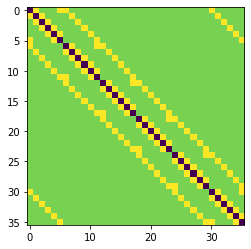

In [808]:
AA = flatten_matrix(A)
plt.imshow(AA) # Для отрисовки приведем ее к обычному виду - квадратному массиву.
plt.show()

In [809]:
nn = int(mt.sqrt(AA.shape[0]))
diag = []
up_diag = []
low_diag = []

for i in range(nn):
    for j in range(nn):
        if (i == j):
            #print(AA[nn*i:nn*(i+1),nn*j:nn*(j+1)])
            diag = diag + [AA[nn*i:nn*(i+1),nn*j:nn*(j+1)]]
        if (j - i) == 1:
            up_diag = up_diag + [AA[nn*i:nn*(i+1),nn*j:nn*(j+1)]]
        if (i-j) == 1:
            low_diag = low_diag + [AA[nn*i:nn*(i+1),nn*j:nn*(j+1)]]

In [810]:
diag

[array([[-36.,   9.,   0.,   0.,   0.,   9.],
        [  9., -36.,   9.,   0.,   0.,   0.],
        [  0.,   9., -36.,   9.,   0.,   0.],
        [  0.,   0.,   9., -36.,   9.,   0.],
        [  0.,   0.,   0.,   9., -36.,   9.],
        [  9.,   0.,   0.,   0.,   9., -36.]]),
 array([[-36.,   9.,   0.,   0.,   0.,   9.],
        [  9., -36.,   9.,   0.,   0.,   0.],
        [  0.,   9., -36.,   9.,   0.,   0.],
        [  0.,   0.,   9., -36.,   9.,   0.],
        [  0.,   0.,   0.,   9., -36.,   9.],
        [  9.,   0.,   0.,   0.,   9., -36.]]),
 array([[-36.,   9.,   0.,   0.,   0.,   9.],
        [  9., -36.,   9.,   0.,   0.,   0.],
        [  0.,   9., -36.,   9.,   0.,   0.],
        [  0.,   0.,   9., -36.,   9.,   0.],
        [  0.,   0.,   0.,   9., -36.,   9.],
        [  9.,   0.,   0.,   0.,   9., -36.]]),
 array([[-36.,   9.,   0.,   0.,   0.,   9.],
        [  9., -36.,   9.,   0.,   0.,   0.],
        [  0.,   9., -36.,   9.,   0.,   0.],
        [  0.,   0.,   9., -

In [812]:
AA.shape

(36, 36)